## Explore the regulatary relationship between gene expression and flux among different reaction

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from scipy.stats import pearsonr
import random

os.chdir(r'D:\code\github\Unified_Yeast_GEMs_Database')

In [172]:
#load data
# expression data
expressionMatrix=pd.read_csv(r'code\6.transcriptomics_ssGEMs_analysis\output\sce969_rxn_expressionMatrix_normalized.csv',index_col=0)
# flux data
# fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/fix_growth_gimme_fba_fluxes.csv',index_col=0)
# fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/PNAS_v3_tissGEMs_sample_flux.csv',index_col=0)
fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/fix_growth_gimme_fba_fluxes_shrinked.csv',index_col=0)
# fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/fix_growth_gimme_pfba_fluxes_shrinked.csv',index_col=0)
# fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/RIPTiDe_integrate_transcriptome/output/allssGEMs_riptide_growth0.2_ethanol5_mean_flux.csv',index_col=0)
# fluxMatrix=pd.read_csv(r'code/6.transcriptomics_ssGEMs_analysis/RIPTiDe_integrate_transcriptome/output/allssGEMs_riptide_growth0.5_ethanol10_mean_flux.csv',index_col=0)
# normalize flux data
# fluxMatrix=fluxMatrix.div(fluxMatrix.loc['r_1714',:],axis=1)*(-100)
fluxMatrix=fluxMatrix.loc[:,fluxMatrix.loc['r_2111',:]>0]
# fill the NaN value with 0
fluxMatrix=fluxMatrix.fillna(0)
# set absolute value of fluxes
fluxMatrix=fluxMatrix.abs()

# remove rows that 99% values are 0
expressionMatrix=expressionMatrix.loc[(expressionMatrix.T!=0).sum()>0.01*expressionMatrix.shape[1],:]
fluxMatrix=fluxMatrix.loc[(fluxMatrix.T!=0).sum()>0.01*fluxMatrix.shape[1],:]

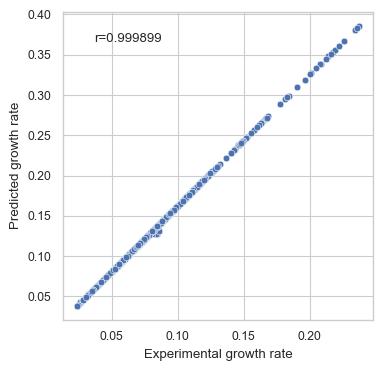

In [173]:
# evaluate the predicted growth rate with the experimental data
growth='r_2111'
pre_growth = fluxMatrix.loc[growth, :]
# remove 0 value
pre_growth = pre_growth[pre_growth != 0]
# load experimental growth rate
# load growth data
df_exp_data = pd.read_csv('data/transcriptomics/combined_969growth_data.csv', index_col=0)
# remove rows with genome_id is NaN
df_exp_data = df_exp_data[df_exp_data['genome_id'].notnull()]
# set genome_id as index
df_exp_data = df_exp_data.set_index('genome_id')
exp_growth = df_exp_data['t_mid_norm']

df_growth=pd.DataFrame(index=pre_growth.index)
df_growth['pre']=pre_growth
df_growth['exp']=df_growth.index.map(exp_growth)
# remove rows with NaN
df_growth=df_growth[df_growth['exp'].notnull()]
# remove predicted growth rate < 0.15
# df_growth=df_growth[df_growth['pre']>0.15]
df_growth['exp']=1/df_growth['exp']

# plot the predicted vs experimental growth rate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('paper')
plt.figure(figsize=(4,4))
sns.scatterplot(x='exp',y='pre',data=df_growth)
plt.xlabel('Experimental growth rate')
plt.ylabel('Predicted growth rate')
# calculate the correlation coefficient
from scipy.stats import spearmanr
r,p=spearmanr(df_growth['exp'],df_growth['pre'])
plt.text(0.1,0.9,'r=%f' %r,transform=plt.gca().transAxes)
plt.show()

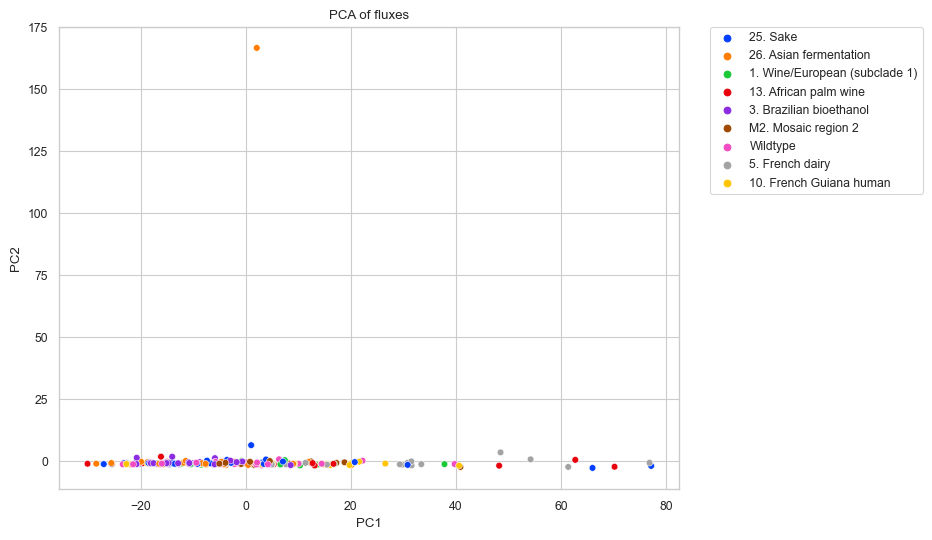

In [174]:
# plot the PCA of the flux data
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data=fluxMatrix.T
# load all strain info
df_strain_info=pd.read_excel(r'data\1897_strains_info.xlsx',index_col=0)
# remove duplicated index
df_strain_info=df_strain_info[~df_strain_info.index.duplicated()]
data['Type']=df_strain_info['nature_clade']
wildtypelist=['14. CHNIII ','20. CHN V ', '15. CHNII ','17. Taiwanese ', '24. Asian islands ', '18. Far East Asia ', '19. Malaysian ', '22. Far East Russian ']
data['Type']=data['Type'].apply(lambda x: 'Wildtype' if x in wildtypelist else x)
keep_clades=data['Type'].value_counts().index[(data['Type'].value_counts()>15)&(data['Type'].value_counts()<40)].tolist()
to_ignores=['1. Wine/European (subclade 4)','1. Wine/European (subclade 3)','8. Mixed origin ']
keep_clades=[x for x in keep_clades if x not in to_ignores]
data=data[data['Type'].isin(keep_clades)]

x1 = StandardScaler().fit_transform(data.drop('Type',axis=1))

# PCA
pca1 = PCA(n_components=2)
principalComponents1 = pca1.fit_transform(x1)

# plot
fig,ax=plt.subplots(figsize=(8,6))
# plot geneMatrix
pca_fluxes=pd.DataFrame(principalComponents1,columns=['PC1','PC2'])
pca_fluxes['Type']=data['Type'].values
sns.scatterplot(x='PC1',y='PC2',hue='Type',data=pca_fluxes,ax=ax,palette='bright')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
# set title
ax.set_title('PCA of fluxes')

# set legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [175]:
common_strains=expressionMatrix.columns.intersection(fluxMatrix.columns)
common_rxns=expressionMatrix.index.intersection(fluxMatrix.index)

expressionMatrix=expressionMatrix.loc[common_rxns,common_strains]
fluxMatrix=fluxMatrix.loc[common_rxns,common_strains]

# z-score normalization
def z_score_convert(df):
    return df.apply(lambda x:(x-x.mean())/x.std(),axis=1)

flux_z_Matrix=z_score_convert(fluxMatrix)
expression_z_Matrix=z_score_convert(expressionMatrix)
# flux_z_Matrix=fluxMatrix
# expression_z_Matrix=expressionMatrix

# remove rows that 99% values are NaN
expression_z_Matrix=expression_z_Matrix.loc[(expression_z_Matrix.T.isna()).sum()<0.01*expression_z_Matrix.shape[1],:]
flux_z_Matrix=flux_z_Matrix.loc[(flux_z_Matrix.T.isna()).sum()<0.01*flux_z_Matrix.shape[1],:]

common_strains=expression_z_Matrix.columns.intersection(flux_z_Matrix.columns)
common_rxns=expression_z_Matrix.index.intersection(flux_z_Matrix.index)

expression_z_Matrix=expression_z_Matrix.loc[common_rxns,common_strains]
flux_z_Matrix=flux_z_Matrix.loc[common_rxns,common_strains]


In [176]:
# calculate the correlation between flux and expression
def calculate_correlation(df1,df2):
    common_rxnList=df1.index.intersection(df2.index)
    
    df_correlation=pd.DataFrame(index=common_rxnList,columns=['correlation','p-value'])
    for rxn in common_rxnList:
        # option 1: use pearsonr correlation
        # df_correlation.loc[rxn,'correlation'],df_correlation.loc[rxn,'p-value']=pearsonr(df1.loc[rxn,:],df2.loc[rxn,:])
        # option 2: use spearman correlation
        from scipy.stats import spearmanr
        df_correlation.loc[rxn,'correlation'],df_correlation.loc[rxn,'p-value']=spearmanr(df1.loc[rxn,:],df2.loc[rxn,:])

    df_correlation=df_correlation.astype(float)
    # fill nan value with 0 in correlation column
    df_correlation['correlation']=df_correlation['correlation'].fillna(0)

    # fill p-value > 0.05 with 0 in correlation column
    # df_correlation=df_correlation.loc[df_correlation['p-value']<0.05,:]
    df_correlation.loc[df_correlation['p-value']>0.05,'correlation']=0
    return df_correlation

flux_expression_r=calculate_correlation(flux_z_Matrix,expression_z_Matrix)

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [177]:
# check the correlation distribution that p-value<0.05
flux_expression_r['correlation'].describe()
# # sort according to the correlation value
# flux_expression_r.sort_values(by='correlation',ascending=False,inplace=True)
# fluxMatrix.loc[flux_expression_r.index[:5]].T.describe()
# save flux_expression_r
flux_expression_r.to_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/flux_expression_correlation.csv')

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


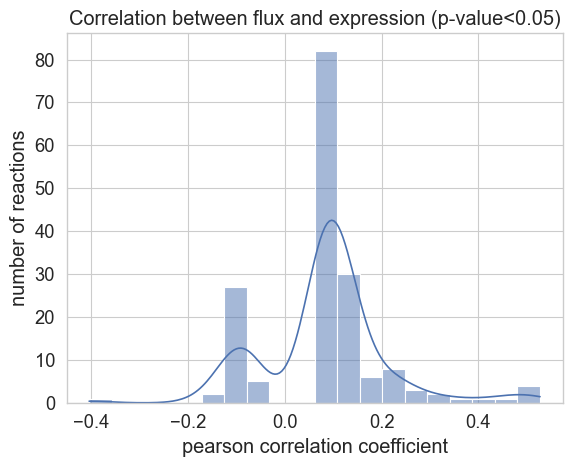

In [178]:
# plot the distribution of correlation
# plot the kde and histogram for flux_expression_r
sns.set_theme(context='paper',style='whitegrid',palette='deep',font='Arial',font_scale=1.5)
sns.histplot(flux_expression_r.loc[flux_expression_r['p-value']<0.05,'correlation'],kde=True,bins=20)
plt.xlabel('pearson correlation coefficient')
plt.ylabel('number of reactions')
plt.title('Correlation between flux and expression (p-value<0.05)')
# set x axis limit
# plt.xlim(-1,1)
plt.show()

In [179]:
# do the enrichment analysis
import gseapy as gp
from gseapy import dotplot

In [180]:
# load reaction pathway dict
import cobra
model=cobra.io.read_sbml_model(r'model/yeast-GEM.xml')
pathway_dict={}
availuable_rxns=flux_z_Matrix.index.tolist()
for group in model.groups:
    name=group.name
    # ignore Transport
    if 'Transport' in name:
        continue
    rxnIDlist=[rxn.id for rxn in group.members if rxn.id in availuable_rxns]
    pathway_dict[name]=rxnIDlist

In [181]:
top_correlation_rxns=flux_expression_r.loc[flux_expression_r['correlation']>0.2].index.tolist()
top_correlation_rxns

['r_0032',
 'r_0163',
 'r_0303',
 'r_0308',
 'r_0445',
 'r_0506',
 'r_0507',
 'r_0508',
 'r_0659',
 'r_0662',
 'r_0815',
 'r_0883',
 'r_2118',
 'r_2119',
 'r_2305',
 'r_1126',
 'r_1128',
 'r_1192',
 'r_1267',
 'r_4226',
 'r_4484']

In [184]:
# do enrichment analysis
enr=gp.enrichr(gene_list=top_correlation_rxns,
               gene_sets=pathway_dict,
               background=fluxMatrix.index.tolist(),
               )
enr.results.sort_values(by='Adjusted P-value',ascending=True,inplace=True)

# save enr.result
enr.results.to_csv(r'code/6.transcriptomics_ssGEMs_analysis/output/flux&expression_enrichment_analysis.csv')
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
5,gs_ind_0,Glyoxylate and dicarboxylate metabolism,2/2,0.000612,0.004895,207.307692,1533.865179,r_0662;r_0445
2,gs_ind_0,Cysteine and methionine metabolism,3/10,0.001503,0.006013,20.218018,131.420153,r_4484;r_0815;r_0308
1,gs_ind_0,Citrate cycle (TCA cycle),3/17,0.007592,0.015184,10.366263,50.594539,r_2305;r_0659;r_0303
7,gs_ind_0,Sulfur metabolism,2/5,0.005842,0.015184,29.505495,151.736412,r_0032;r_0883
3,gs_ind_0,"Glycine, serine and threonine metabolism",3/22,0.015838,0.025340,7.659737,31.752465,r_0507;r_0506;r_0508
6,gs_ind_0,"Phenylalanine, tyrosine and tryptophan biosynt...",2/20,0.088289,0.117719,5.478170,13.296272,r_2118;r_2119
0,gs_ind_0,"Alanine, aspartate and glutamate metabolism",1/11,0.247217,0.282534,5.564460,7.776270,r_4226
4,gs_ind_0,Glycolysis / gluconeogenesis,1/19,0.389176,0.389176,3.126566,2.950610,r_0163


d:\softwares\programming\anoconda\envs\gem\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


<Axes: title={'center': 'Highly correlated reactions'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

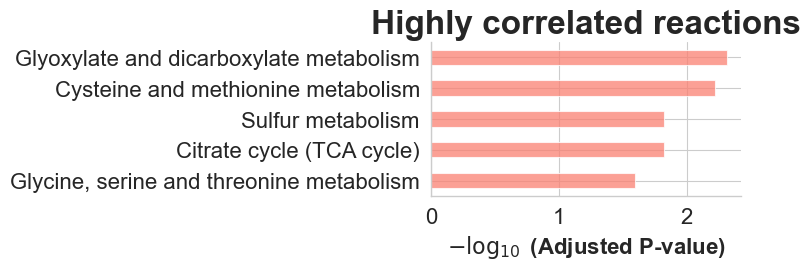

In [185]:
from gseapy import barplot

barplot(enr.results,
                column='Adjusted P-value',
                    title='Highly correlated reactions',cutoff=0.05,figsize=(4,2))

2024-03-26 09:55:44,370 [WARNING] Duplicated values found in preranked stats: 80.82% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-26 09:55:44,370 [INFO] Parsing data files for GSEA.............................
2024-03-26 09:55:44,371 [INFO] 0042 gene_sets have been filtered out when max_size=1000 and min_size=3
2024-03-26 09:55:44,372 [INFO] 0036 gene_sets used for further statistical testing.....
2024-03-26 09:55:44,372 [INFO] Start to run GSEA...Might take a while..................
2024-03-26 09:55:44,434 [INFO] Congratulations. GSEApy runs successfully................

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


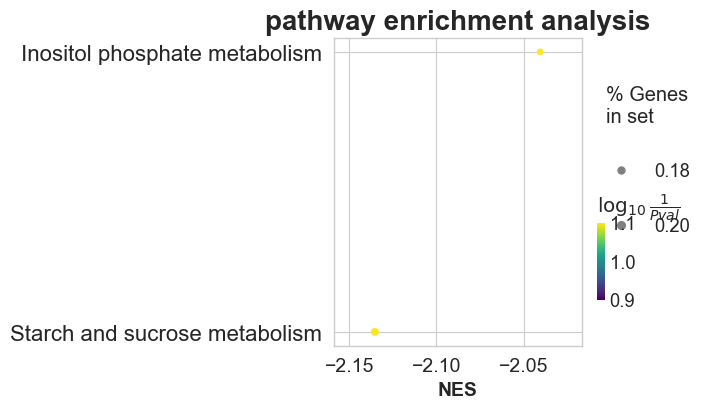

In [186]:
# propare the pre-ranked gene list
df_gene_list=flux_expression_r['correlation'].sort_values(ascending=False)
df_gene_list=pd.DataFrame(df_gene_list)

# do the gsea analysis
pre_res = gp.prerank(rnk=df_gene_list, # or rnk = rnk,
                     gene_sets=pathway_dict,
                     min_size=3,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

pre_res.res2d.sort_values(by='NOM p-val',ascending=True)

# plot
ax = dotplot(pre_res.res2d,
             column="NOM p-val", 
            #  column='FDR q-val',
             title='pathway enrichment analysis',
             cmap=plt.cm.viridis,
             size=6, # adjust dot size
             figsize=(4,4), 
             cutoff=0.05,
             show_ring=False)

### 2.Difference of transcription&flux regulation among different growth type

In [187]:
# extract strains for different growth type
df_growth_data=pd.read_csv('data/transcriptomics/combined_969growth_data.csv',index_col=0)
# remove rows with genome_id is NaN
df_growth_data=df_growth_data[df_growth_data['genome_id'].notnull()]
#set genome_id as index
df_growth_data=df_growth_data.set_index('genome_id')

# only keep strains exist in rxn_fcMatrix column and df_strain_info index
df_growth_data=df_growth_data[df_growth_data.index.isin(common_strains)]

# sort by t_mid_norm
df_growth_data=df_growth_data.sort_values(by=['t_mid_norm'])

# extract top 50 as fast , bottom 50 as slow, and middle 50 as medium
middle_num=math.floor(df_growth_data.shape[0]/2)
fast_strainlist=df_growth_data.index[:50].tolist()
medium_strainlist=df_growth_data.index[middle_num-25:middle_num+25].tolist()
slow_strainlist=df_growth_data.index[-50:].tolist()

In [188]:
def calculate_subpop_correlation(df1,df2,strainlist):
    df1=df1.loc[:,strainlist]
    df2=df2.loc[:,strainlist]
    
    return calculate_correlation(df1,df2)

fast_flux_expression_r=calculate_subpop_correlation(flux_z_Matrix,expression_z_Matrix,fast_strainlist)
medium_flux_expression_r=calculate_subpop_correlation(flux_z_Matrix,expression_z_Matrix,medium_strainlist)
slow_flux_expression_r=calculate_subpop_correlation(flux_z_Matrix,expression_z_Matrix,slow_strainlist)

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [189]:
df_growth_type_corr=pd.DataFrame({'fast':fast_flux_expression_r['correlation'],'medium':medium_flux_expression_r['correlation'],'slow':slow_flux_expression_r['correlation']})
# fill nan value with 0
df_growth_type_corr=df_growth_type_corr.fillna(0)
df_growth_type_corr.describe()

,fast,medium,slow
count,829.000000,829.000000,829.000000
mean,0.003429,0.011640,-0.002612
std,0.069950,0.100187,0.098744
min,-0.548071,-0.465440,-0.462388
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.545612,0.662938,0.628644


fast 0.05318667754529729
medium 1.0
slow 0.0035812767553515157


C:\Users\wangh\AppData\Local\Temp\ipykernel_10508\4240168129.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_growth_type_corr.loc[~(df_growth_type_corr==0).all(axis=1)],shade=True)
d:\softwares\programming\anoconda\envs\gem\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


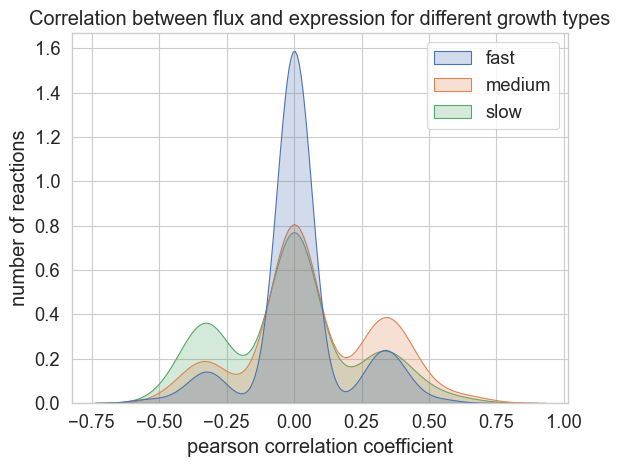

In [190]:
# calculate the p value for each growth types compare to medium growth type
from scipy.stats import ttest_ind
for growth_type in df_growth_type_corr.columns:
    print(growth_type,ttest_ind(df_growth_type_corr['medium'],df_growth_type_corr[growth_type])[1])

# plot the distribution of correlation for different growth types
sns.set_theme(context='paper',style='whitegrid',palette='deep',font='Arial',font_scale=1.5)
sns.kdeplot(data=df_growth_type_corr.loc[~(df_growth_type_corr==0).all(axis=1)],shade=True)
plt.xlabel('pearson correlation coefficient')
plt.ylabel('number of reactions')
plt.title('Correlation between flux and expression for different growth types')
plt.show()

In [191]:
# Prepare for enrichment analysis
# top=20
# fast_top_rxns=fast_flux_expression_r.loc[fast_flux_expression_r['p-value']<0.05,'correlation'].sort_values(ascending=False).index[:top].tolist()
# medium_top_rxns=medium_flux_expression_r.loc[medium_flux_expression_r['p-value']<0.05,'correlation'].sort_values(ascending=False).index[:top].tolist()
# slow_top_rxns=slow_flux_expression_r.loc[slow_flux_expression_r['p-value']<0.05,'correlation'].sort_values(ascending=False).index[:top].tolist()

threshold=0.2
fast_top_rxns=fast_flux_expression_r.loc[fast_flux_expression_r['correlation']>threshold,'correlation'].sort_values(ascending=False).index.tolist()
medium_top_rxns=medium_flux_expression_r.loc[medium_flux_expression_r['correlation']>threshold,'correlation'].sort_values(ascending=False).index.tolist()
slow_top_rxns=slow_flux_expression_r.loc[slow_flux_expression_r['correlation']>threshold,'correlation'].sort_values(ascending=False).index.tolist()
# # check the top rxn correlation value
print('fast:',fast_flux_expression_r.loc[fast_top_rxns[-1],'correlation'])
print('medium:',medium_flux_expression_r.loc[medium_top_rxns[-1],'correlation'])
print('slow:',slow_flux_expression_r.loc[slow_top_rxns[-1],'correlation'])

# prepare background
backgroud=flux_z_Matrix.index.tolist()

fast: 0.2812173998268633
medium: 0.2809603841536614
slow: 0.2807850000417449


In [192]:
# do enrichment analysis
from gseapy import barplot
def enr_analysis(rxnList,pathway_dict,background,title='enrichment analysis'):
    enr=gp.enrichr(gene_list=rxnList,
                   gene_sets=pathway_dict,
                   background=background,
                   outdir=None,
                   no_plot=True)
    
    # plot
    try:
        ax=barplot(enr.res2d,
                column='Adjusted P-value',
                    title=title,cutoff=0.05,figsize=(4,2))
    except:
        print('No significant enrichment')
    return enr.res2d


d:\softwares\programming\anoconda\envs\gem\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
d:\softwares\programming\anoconda\envs\gem\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
d:\softwares\programming\anoconda\envs\gem\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


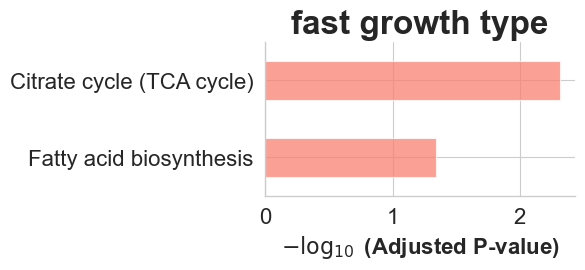

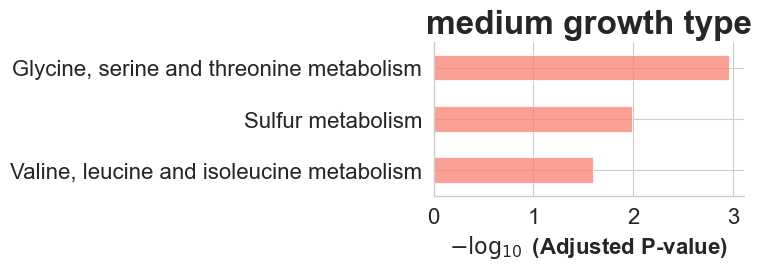

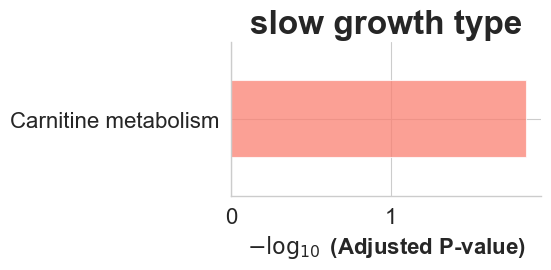

In [193]:
# fast growth type
fast_enr=enr_analysis(fast_top_rxns,pathway_dict,backgroud,title='fast growth type')
# medium growth type
medium_enr=enr_analysis(medium_top_rxns,pathway_dict,backgroud,title='medium growth type')
# slow growth type
slow_enr=enr_analysis(slow_top_rxns,pathway_dict,backgroud,title='slow growth type')

2024-03-26 09:56:31,044 [WARNING] Duplicated values found in preranked stats: 96.26% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-03-26 09:56:31,045 [INFO] Parsing data files for GSEA.............................
2024-03-26 09:56:31,046 [INFO] 0042 gene_sets have been filtered out when max_size=1000 and min_size=3
2024-03-26 09:56:31,046 [INFO] 0036 gene_sets used for further statistical testing.....
2024-03-26 09:56:31,046 [INFO] Start to run GSEA...Might take a while..................
2024-03-26 09:56:31,095 [INFO] Congratulations. GSEApy runs successfully................

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\gseapy\plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
2024-03-26 09:56:31,126 [WARNING] Duplicated values found in preranked stats: 93.00% of genes
The order of those genes will be arbitrary, which may p

no significant result
       Name                                               Term        ES  \
0   prerank            Biosynthesis of unsaturated fatty acids  -0.99271   
1   prerank                    Fructose and mannose metabolism -0.987893   
2   prerank                            Glycerolipid metabolism -0.876473   
3   prerank                              Riboflavin metabolism -0.531853   
4   prerank               Porphyrin and chlorophyll metabolism -0.483016   
5   prerank  Phenylalanine, tyrosine and tryptophan biosynt...  0.995056   
6   prerank                            Fatty acid biosynthesis  0.991358   
7   prerank                          Citrate cycle (TCA cycle)  0.970443   
8   prerank          Valine, leucine and isoleucine metabolism  0.952147   
9   prerank        Alanine, aspartate and glutamate metabolism  0.968215   
10  prerank                                    tRNA metabolism  0.948084   
11  prerank                 Cysteine and methionine metabolism  0.

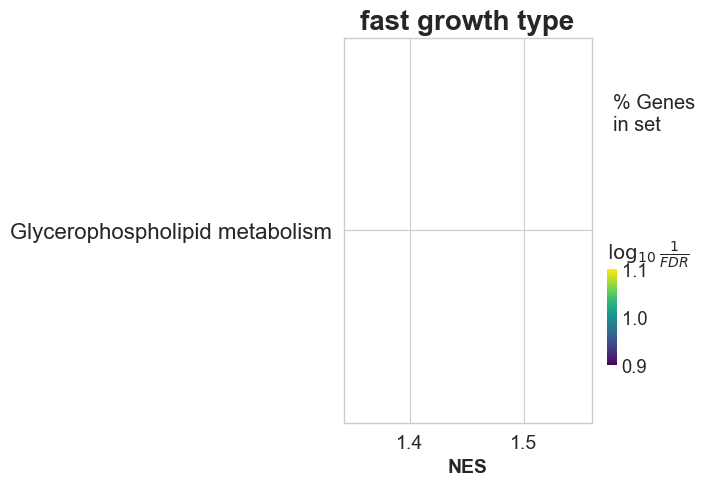

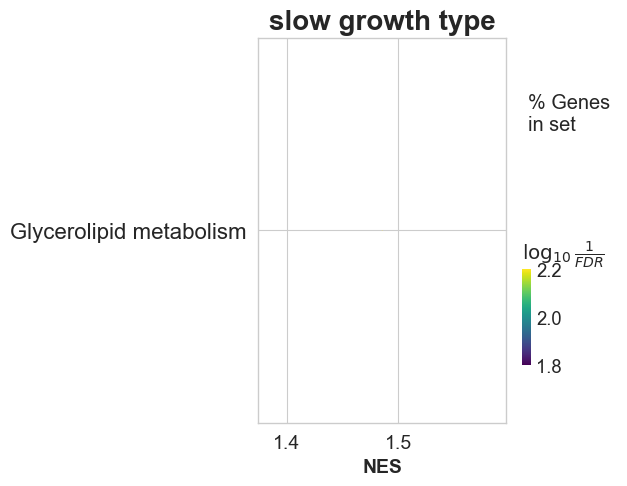

In [194]:
# prerank gsea analysis
def gsea_analysis(df_correlation,pathway_dict,title='pathway enrichment analysis'):
    # prepare the pre-ranked list
    df_rxn_list=df_correlation['correlation'].sort_values(ascending=False)
    df_rxn_list=pd.DataFrame(df_rxn_list)

    pre_res = gp.prerank(rnk=df_rxn_list, # or rnk = rnk,
                     gene_sets=pathway_dict,
                     min_size=3,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

    pre_res.res2d

    # plot
    try:
        ax = dotplot(pre_res.res2d,
                    #  column="NOM p-val", 
                    column='FDR q-val',
                    title=title,
                    cmap=plt.cm.viridis,
                    size=4, # adjust dot size
                    figsize=(4,5), 
                    cutoff=0.25,
                    show_ring=False)
    except:
        print('no significant result')
        print(pre_res.res2d)
    return pre_res.res2d

fast_gsea_result=gsea_analysis(df_correlation=fast_flux_expression_r,pathway_dict=pathway_dict,title='fast growth type')
medium_gsea_result=gsea_analysis(df_correlation=medium_flux_expression_r,pathway_dict=pathway_dict,title='medium growth type')
slow_gsea_result=gsea_analysis(slow_flux_expression_r,pathway_dict,title='slow growth type')

### 3.different clade analysis

In [195]:
# load all strain info
df_strain_info=pd.read_excel(r'data\1897_strains_info.xlsx',index_col=0)

# remove rows with NaN value in nature_clade
df_strain_info=df_strain_info[~df_strain_info['nature_clade'].isna()]

# only keep strain that exist in rxn_fcMatrix columns
df_strain_info=df_strain_info.loc[df_strain_info.index.isin(fluxMatrix.columns)]
df_strain_info['nature_clade'].value_counts()

nature_clade
1. Wine/European                 233
M3. Mosaic region 3               71
25. Sake                          39
1. Wine/European (subclade 4)     35
26. Asian fermentation            34
3. Brazilian bioethanol           32
8. Mixed origin                   29
10. French Guiana human           28
13. African palm wine             21
1. Wine/European (subclade 3)     20
5. French dairy                   17
1. Wine/European (subclade 1)     17
M2. Mosaic region 2               17
7. Mosaic beer                    14
23. North American oak            13
M3. Mosaic region 3               13
2. Alpechin                       13
12. West African cocoa            12
24. Asian islands                 10
M1. Mosaic region 1               10
6. African beer                    9
18. Far East Asia                  8
1. Wine/European (subclade 2)      7
4. Mediterranean oak               7
21. Ecuadorean                     7
9. Mexican agave                   5
19. Malaysian            

In [196]:
# wildtypelist=['14. CHNIII ','20. CHN V ', '15. CHNII ','17. Taiwanese ', '24. Asian islands ', '18. Far East Asia ', '19. Malaysian ', '22. Far East Russian ']
wildtypelist=['14. CHNIII ','20. CHN V ', '15. CHNII ','17. Taiwanese ','24. Asian islands ', '18. Far East Asia ', '19. Malaysian ', '22. Far East Russian ']
# only keep clades with more than 10 strains
check_cladelist=df_strain_info['nature_clade'].value_counts()[df_strain_info['nature_clade'].value_counts()>15].index.tolist()
wt_strainlist=df_strain_info[df_strain_info['nature_clade'].isin(wildtypelist)].index.tolist()
check_clades_dict=dict()
# sample 20 strains from wildtype
sample_number=15
random.seed(123)
# wt_strainlist=random.sample(wt_strainlist,sample_number)
check_clades_dict['wildtype']=wt_strainlist
print('wildtype',len(set(wt_strainlist)))
for clade in check_cladelist:
    strainlist=df_strain_info[df_strain_info['nature_clade']==clade].index.tolist()
    if len(strainlist)<sample_number:
        continue
    else:
        # sample 20 strains from each clade
        random.seed(123)
        # strainlist=random.sample(strainlist,sample_number)
        strainlist=strainlist
    check_clades_dict[clade]=strainlist
    print(clade,len(set(strainlist)))

wildtype 35
1. Wine/European  233
M3. Mosaic region 3 71
25. Sake  39
1. Wine/European (subclade 4) 35
26. Asian fermentation  34
3. Brazilian bioethanol  32
8. Mixed origin  29
10. French Guiana human  28
13. African palm wine  21
1. Wine/European (subclade 3) 20
5. French dairy  17
1. Wine/European (subclade 1) 17
M2. Mosaic region 2 17


In [197]:
df_clades_corr=pd.DataFrame(index=flux_z_Matrix.index)
for clade in check_clades_dict.keys():
    strainlist=check_clades_dict[clade]
    df_clades_corr[clade]=calculate_subpop_correlation(flux_z_Matrix,expression_z_Matrix,strainlist)['correlation']

# remove rows with all nan value
df_clades_corr.dropna(axis=0,how='all',inplace=True)
# remove rows with all 0 value
df_clades_corr=df_clades_corr.loc[(df_clades_corr.T!=0).sum()>0]

df_clades_corr.describe()

d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\softwares\programming\anoconda\envs\gem\lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
d:\softwares\programming\anoconda\envs\g

,wildtype,1. Wine/European,M3. Mosaic region 3,25. Sake,1. Wine/European (subclade 4),26. Asian fermentation,3. Brazilian bioethanol,8. Mixed origin,10. French Guiana human,13. African palm wine,1. Wine/European (subclade 3),5. French dairy,1. Wine/European (subclade 1),M2. Mosaic region 2
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,0.033509,0.007884,0.023596,0.034477,0.034871,0.032993,0.009795,0.010936,0.024149,0.018485,0.052654,0.020121,0.066038,0.009531
std,0.142489,0.100554,0.114090,0.156397,0.157382,0.157765,0.151440,0.134054,0.143125,0.176985,0.199839,0.147529,0.223947,0.132841
min,-0.409513,-0.462596,-0.336563,-0.436065,-0.468408,-0.449182,-0.512101,-0.508374,-0.474938,-0.669111,-0.619549,-0.664216,-0.651961,-0.695220
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.583473,0.590884,0.648553,0.736313,0.659151,0.739951,0.824706,0.583417,0.753450,0.724569,0.788860,0.694861,0.701109,0.776834


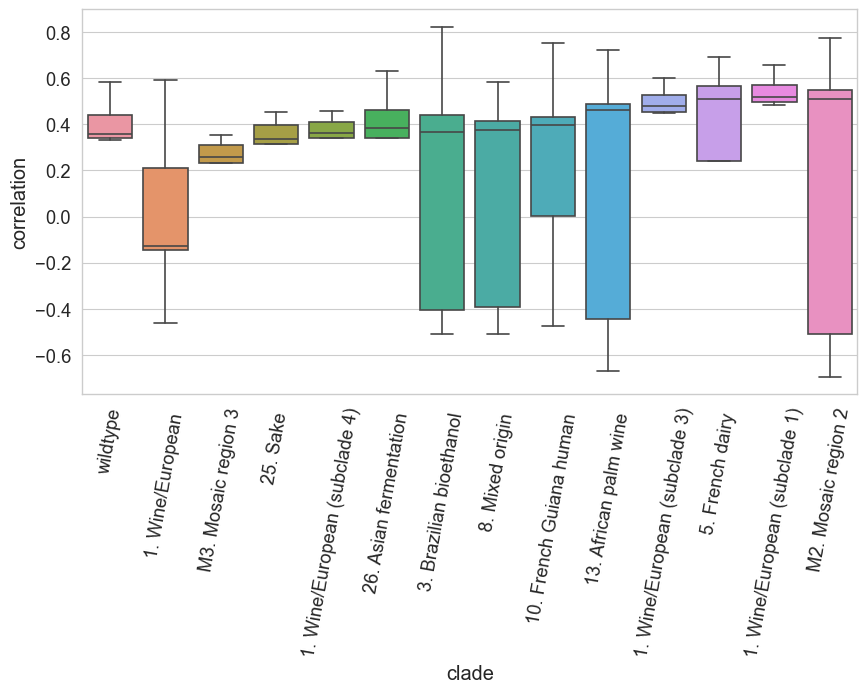

In [198]:
import seaborn as sns
# plot the boxplot of correlation for different clades
fig,ax=plt.subplots(figsize=(10,5))
sns.boxplot(data=df_clades_corr[df_clades_corr!=0],ax=ax,showfliers=False)
plt.xlabel('clade')
plt.ylabel('correlation')
plt.xticks(rotation=80)
plt.show()

In [199]:
# do enrichment analysis for high correlation reactions
def enr_analysis(rxnList,pathway_dict,background=None,cutoff=0.05):
    enr=gp.enrich(gene_list=rxnList, # or gene_list=glist
                 gene_sets=pathway_dict,
                 background=background, 
                 outdir=None,
                 verbose=None)
    result=enr.res2d
    result=result[result['P-value']<cutoff]
    # set Term as index
    result=result.set_index('Term')
    return result

In [200]:
threshold=0.2
high_corr_rxn_dict=dict()
# check the number of reactions with correlation > threshold
for clade in df_clades_corr.columns:
    print(clade,df_clades_corr.loc[df_clades_corr[clade]>threshold].shape[0])
    high_corr_rxn_dict[clade]=df_clades_corr.loc[df_clades_corr[clade]>threshold].index.tolist()
    # get the top 20 reactions
    # high_corr_rxn_dict[clade]=df_clades_corr.loc[df_clades_corr[clade]>threshold].sort_values(by=clade,ascending=False).index.tolist()[:20]
    # print(clade,high_corr_rxn_dict[clade][-1])


backgroud=fluxMatrix.index.tolist()

wildtype 39
1. Wine/European  18
M3. Mosaic region 3 40
25. Sake  49
1. Wine/European (subclade 4) 47
26. Asian fermentation  38
3. Brazilian bioethanol  24
8. Mixed origin  24
10. French Guiana human  32
13. African palm wine  31
1. Wine/European (subclade 3) 50
5. French dairy  21
1. Wine/European (subclade 1) 57
M2. Mosaic region 2 14


In [201]:
# do enrichment analysis of high correlation reactions for each clade
df_clades_score=pd.DataFrame(index=pathway_dict.keys())
df_clades_pvalue=pd.DataFrame(index=pathway_dict.keys())
for clade in high_corr_rxn_dict.keys():
    rxnList=high_corr_rxn_dict[clade]
    result=enr_analysis(rxnList,pathway_dict,backgroud,cutoff=0.05)
    df_clades_score[clade]=result['Combined Score']
    df_clades_pvalue[clade]=result['P-value']

# remove rows with all nan value
df_clades_score.dropna(axis=0,how='all',inplace=True)
# fill nan value with 0
df_clades_score.fillna(0,inplace=True)
df_clades_score


,wildtype,1. Wine/European,M3. Mosaic region 3,25. Sake,1. Wine/European (subclade 4),26. Asian fermentation,3. Brazilian bioethanol,8. Mixed origin,10. French Guiana human,13. African palm wine,1. Wine/European (subclade 3),5. French dairy,1. Wine/European (subclade 1),M2. Mosaic region 2
"Alanine, aspartate and glutamate metabolism",0.000000,0.000000,0.000000,0.000000,27.875102,0.000000,0.0,30.541731,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arginine biosynthesis,254.586336,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,137.060968,0.000000
Biosynthesis of unsaturated fatty acids,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.748510
Cellular response to anaerobic conditions,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,108.405145
Citrate cycle (TCA cycle),0.000000,66.204953,0.000000,0.000000,0.000000,223.303955,0.0,0.000000,0.000000,25.188433,0.000000,0.000000,0.000000,0.000000
Cysteine and methionine metabolism,0.000000,0.000000,0.000000,0.000000,33.895417,0.000000,0.0,248.264215,0.000000,0.000000,0.000000,44.858545,0.000000,85.618540
"Glycine, serine and threonine metabolism",0.000000,181.139552,114.569041,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,70.329926,19.396191,0.000000
Glyoxylate and dicarboxylate metabolism,0.000000,1897.348036,0.000000,466.345628,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,204.885777
Histidine metabolism,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,871.853918,0.000000,0.000000,0.000000,0.000000,0.000000
Inositol phosphate metabolism,0.000000,0.000000,0.000000,28.350857,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,108.929985,0.000000,0.000000


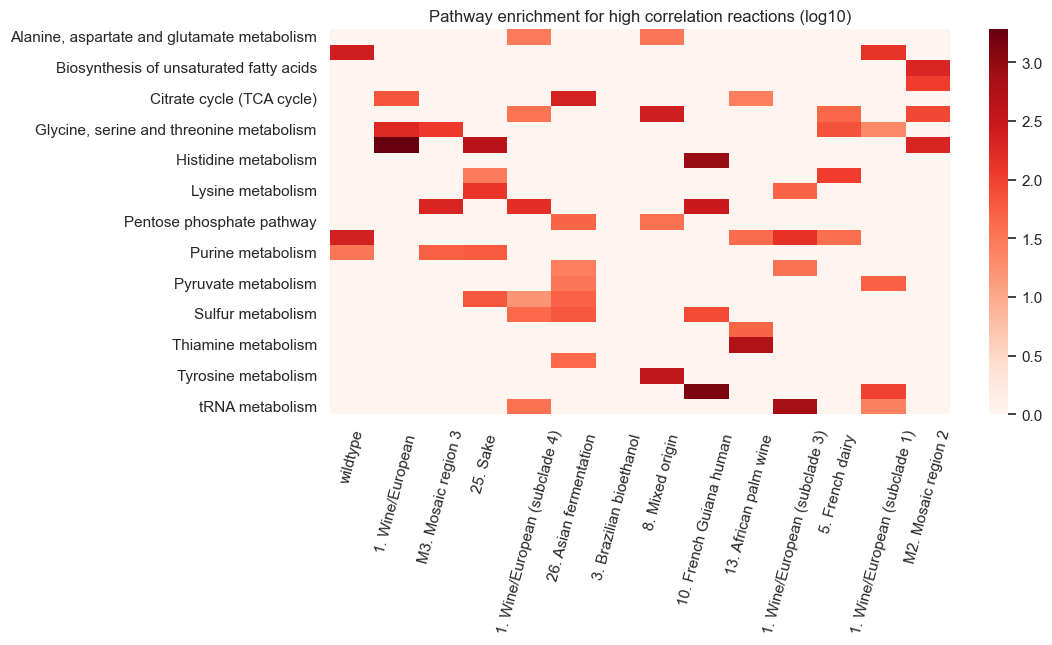

In [202]:
# plot the enrichment score as heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# set font style as Arial
plt.rcParams['font.sans-serif'] = ['Arial']
plt.figure(figsize=(10, 5))
df_clades_score_log=np.log10(df_clades_score+1)
sns.heatmap(df_clades_score_log, cmap="Reds")
plt.title('Pathway enrichment for high correlation reactions (log10)')
plt.xticks(rotation=75)
# # set color bar title
# cbar = plt.gca().collections[0].colorbar
# cbar.set_label('Enrichment score (log10)')
plt.show()